In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as pltcolors
import pandas as pd
import numpy as np
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors as mcolors
from matplotlib import cm
import matplotlib.dates as mdates
from beautifultable import BeautifulTable
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.5f' % x)

#https://ballotpedia.org/U.S._House_battlegrounds,_2020

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

def get_state_name_from_bg_column( state_str ):
    state_str = state_str.split( '\'' )
    state_str[ 1 ] = state_str[ 1 ].replace( '\'', '' )
    state_str[ 1 ] = state_str[ 1 ].replace( ' ', '' )
    if state_str[ 1 ][ 0 ] == 's':
        state_str[ 1 ] = state_str[ 1 ][ 1: ]
    state_str[ 0 ] = state_str[ 0 ].rstrip()
    return state_str #returns an array

def strip_state_ordinal( state_str ):
    ords = ['st', 'nd', 'rd', 'th' ]
    for o in ords:
        state_str = state_str.replace( o, '' )
    return state_str

def get_district_name_from_state( row ):
    state = us_state_abbrev[ get_state_name_from_bg_column( row[ 'dist' ] )[ 0 ] ]
    district = strip_state_ordinal( get_state_name_from_bg_column( row[ 'dist' ] )[ 1 ] )
    return state + '_' + district

def get_max_spend_value_for_seat( seat ):
    return house[ house[ 'seat' ] == seat ][ 'fbandg_since010619' ].max()

def get_max_spend_party_for_seat( seat, max_spend_value ):
    return house[ ( house[ 'seat' ] == seat ) & ( house[ 'fbandg_since010619' ] == max_spend_value ) ][ 'Party' ].values[ 0 ]

house = pd.read_excel( 
        open( 'house.xlsx', 'rb' ), sheet_name='Sheet1', 
        header=0 )
bg_house = pd.read_excel(
        open( 'bg_house.xlsx', 'rb' ), sheet_name = 'Sheet 1', 
            header = None )
bg_house.columns = ['dist', 'rep', 'open_seat', '2018_margin']
bg_house = bg_house[:-1]

house = house.drop( ['tv_010119to102520', 'per_tvcycle', 'tv_101220to102520', 'per_tvsince1011'], axis=1 )

#only care about REP and DEM
house = house[ house[ 'Party' ].isin( [ 'REP', 'DEM' ] ) ]

house[ 'seat' ] = house[ 'State' ] + '_' + house[ 'District' ].astype( 'str' )

bg_house[ 'seat' ] = bg_house.apply( lambda row: get_district_name_from_state( row ), axis=1 )

house = pd.merge( left=house, right=bg_house, on='seat', how='left', suffixes=("_house", "_bg") )

house[ 'battleground' ] = house[ 'dist' ].apply( lambda x: True if isinstance( x, str ) else False )

#only take the top 2 from each race
house = house.sort_values( ['seat', 'fbandg_since010619'], axis=0, ascending=False).groupby('seat').head( 2 )

house[ 'max_spend_value' ] = house.apply( lambda x: get_max_spend_value_for_seat( x[ 'seat' ] ), axis=1 )
house[ 'max_spend_party' ] = house.apply( lambda x: get_max_spend_party_for_seat( x[ 'seat' ], x[ 'max_spend_value' ] ), axis=1 )
house[ 'diff_from_max' ] = house.apply( lambda x: x[ 'fbandg_since010619' ] - x[ 'max_spend_value' ] if x[ 'max_spend_value' ] != x[ 'fbandg_since010619' ] else 0, axis=1 ) 

house.head()

,State,District,Party,Candidate,fbandg_since010619,fbandg_since101120,fec_id,seat,dist,rep,open_seat,2018_margin,battleground,max_spend_value,max_spend_party,diff_from_max
1385,WY,0,REP,"Cheney, Elizabeth Mrs.",25442,0,H6WY00159,WY_0,NaN,NaN,NaN,NaN,False,25442,REP,0
1387,WY,0,DEM,"Grey Bull, Lynnette",5080,0,H0WY01036,WY_0,NaN,NaN,NaN,NaN,False,25442,REP,-20362
348,WV,3,DEM,"Turner, Hilary",10141,5534,H0WV03151,WV_3,NaN,NaN,NaN,NaN,False,10141,DEM,0
1384,WV,3,DEM,"Davis, Paul E",100,0,H0WV03177,WV_3,NaN,NaN,NaN,NaN,False,10141,DEM,-10041
276,WV,2,DEM,"Kunkel, Catherine",15433,7265,H0WV02179,WV_2,NaN,NaN,NaN,NaN,False,15433,DEM,0


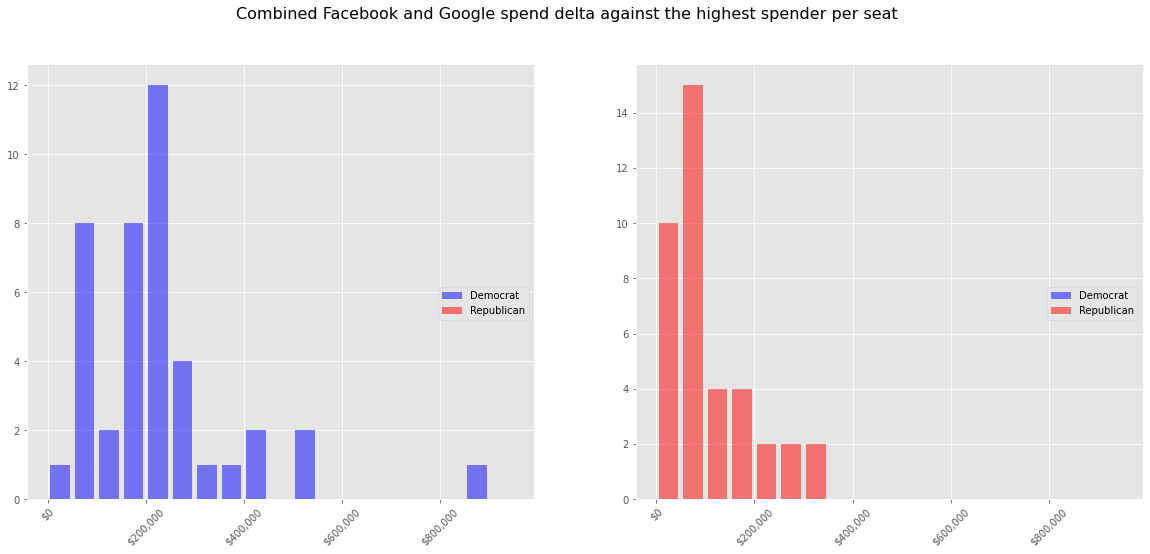

"\nfig, ax1 = plt.subplots()\nplt.rcParams[ 'figure.figsize' ] = [ 20, 8 ]\nplt.style.use('ggplot')\n#plt.hist( dem[ 'fbandg_since010619' ], bins = range(0, 1000000, 50000), alpha=.5, rwidth=1, color='blue')\nplt.hist( rep[ 'fbandg_since010619' ], bins = range(0, 1000000, 50000), alpha=.5, rwidth=1, color='red')\nax1.xaxis.set_major_locator(MaxNLocator(float=True))\nax1.ticklabel_format(useOffset=False, style='plain')\n#ax1.get_xaxis().set_major_formatter(\n#    plt.FuncFormatter(lambda x, p: format(int(x), ',')))\nfmt = '${x:,.0f}'\ntick = mtick.StrMethodFormatter(fmt)\nax1.xaxis.set_major_formatter(tick) \nplt.show()\n"

In [174]:
# house[ house[ 'Party' ].isin( ['REP', 'DEM' ] ) ].groupby( 'Party' ).fbandg_since010619.hist()
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick

#remove AOC: ( house[ 'fec_id' ] != 'H8NY15148' ) &
house = house[ ( house[ 'battleground'] == True ) ]

dem = house[ ( house[ 'Party' ].isin( [ 'DEM' ] ) ) ].sort_values( 'seat', axis=0, ascending=False )
rep = house[ house[ 'Party' ].isin( [ 'REP' ] ) ].sort_values( 'seat', axis=0, ascending=False )

fig, ax1 = plt.subplots( nrows=1, ncols=2 )
plt.rcParams[ 'figure.figsize' ] = [ 20, 8 ]
plt.style.use('ggplot')

ax1[ 0 ].hist( dem[ 'fbandg_since010619' ], bins = range(0, 1000000, 50000), alpha=.5, rwidth=.8, color='blue', label='Democrat')
ax1[ 1 ].hist( rep[ 'fbandg_since010619' ], bins = range(0, 1000000, 50000), alpha=.5, rwidth=.8, color='red', label='Republican')

for i in range( 2 ):
    #ax1[ i ].xaxis.set_major_locator(MaxNLocator(float=True))
    #ax1[ i ].ticklabel_format(useOffset=False, style='plain')

    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax1[ i ].xaxis.set_major_formatter(tick)
    
    plt.setp(ax1[ i ].xaxis.get_majorticklabels(), rotation=45)
        
    fig.legend(loc=1, bbox_to_anchor=(1,0.5), bbox_transform=ax1[ i ].transAxes)
    
fig.suptitle( 'Combined Facebook and Google spend delta against the highest spender per seat', fontsize=16 )

plt.show()

'''
fig, ax1 = plt.subplots()
plt.rcParams[ 'figure.figsize' ] = [ 20, 8 ]
plt.style.use('ggplot')
#plt.hist( dem[ 'fbandg_since010619' ], bins = range(0, 1000000, 50000), alpha=.5, rwidth=1, color='blue')
plt.hist( rep[ 'fbandg_since010619' ], bins = range(0, 1000000, 50000), alpha=.5, rwidth=1, color='red')
ax1.xaxis.set_major_locator(MaxNLocator(float=True))
ax1.ticklabel_format(useOffset=False, style='plain')
#ax1.get_xaxis().set_major_formatter(
#    plt.FuncFormatter(lambda x, p: format(int(x), ',')))
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.xaxis.set_major_formatter(tick) 
plt.show()
'''

In [151]:
dem.fbandg_since010619.describe()

count       42.00000
mean    227321.90476
std     157474.84983
min      28947.00000
25%     118088.25000
50%     210503.50000
75%     252503.25000
max     894569.00000
Name: fbandg_since010619, dtype: float64

In [152]:
rep.fbandg_since010619.describe()

count       39.00000
mean    110076.43590
std      85742.76070
min      15045.00000
25%      50386.50000
50%      77426.00000
75%     152374.00000
max     332936.00000
Name: fbandg_since010619, dtype: float64

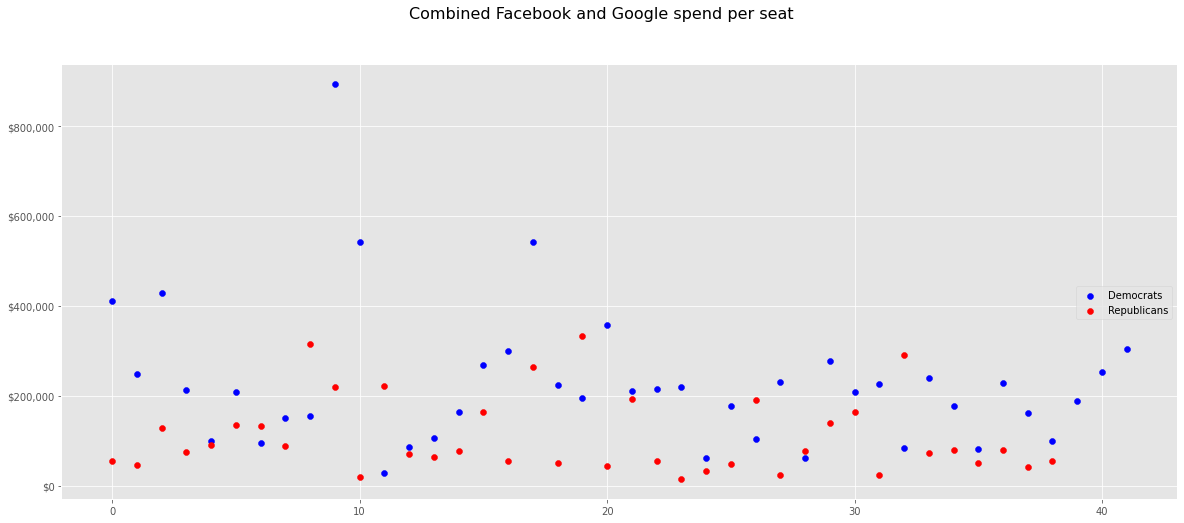

In [169]:
fig, ax1 = plt.subplots()
ax1.scatter(range(len(dem)), dem.fbandg_since010619.tolist(), color='blue', label='Democrats')
ax1.scatter(range(len(rep)), rep.fbandg_since010619.tolist(), color='red', label='Republicans')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
fig.legend(loc=1, bbox_to_anchor=(1,0.5), bbox_transform=ax1.transAxes)
fig.suptitle( 'Combined Facebook and Google spend per seat', fontsize=16 )
plt.show()

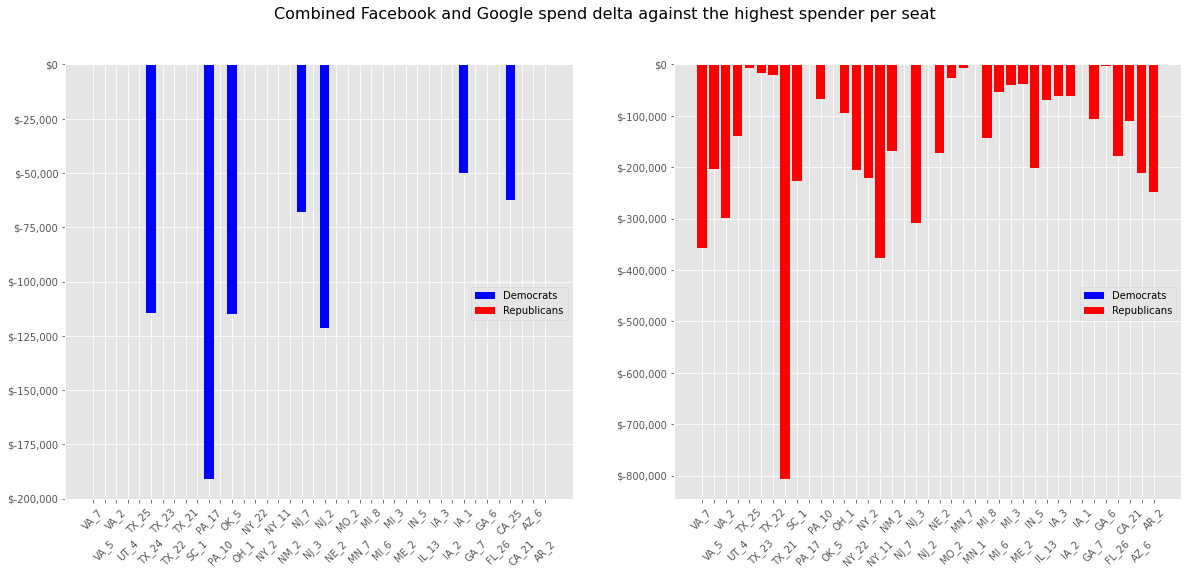

In [168]:
fig, ax1 = plt.subplots( nrows=1, ncols=2 )
plt.rcParams[ 'figure.figsize' ] = [ 20, 8 ]
plt.style.use('ggplot')

ax1[ 0 ].bar( dem.seat, dem.diff_from_max, color='blue', label='Democrats' )
ax1[ 1 ].bar( rep.seat, rep.diff_from_max, color='red', label='Republicans' )

for i in range( 2 ):
    #ax1[ i ].xaxis.set_major_locator(MaxNLocator(float=True))
    #ax1[ i ].ticklabel_format(useOffset=False, style='plain')

    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax1[ i ].yaxis.set_major_formatter(tick)
    
    plt.setp(ax1[ i ].xaxis.get_majorticklabels(), rotation=45)
    
    for tick in ax1[ i ].xaxis.get_major_ticks()[1::2]:
        tick.set_pad( 35 )
        
    fig.legend(loc=1, bbox_to_anchor=(1,0.5), bbox_transform=ax1[ i ].transAxes)
    
fig.suptitle( 'Combined Facebook and Google spend delta against the highest spender per seat', fontsize=16 )

plt.show()

In [129]:
print( dem )

     State  District Party                   Candidate  fbandg_since010619  \
12      VA         7   DEM         Spanberger, Abigail              412168   
32      VA         5   DEM        Webb, Bryant Cameron              249123   
35      VA         2   DEM               Luria, Elaine              428703   
66      UT         4   DEM                Mcadams, Ben              213603   
79      TX        25   DEM          Oliver, Julie Lynn               98657   
75      TX        24   DEM         Valenzuela, Candace              209358   
1381    TX        24   DEM           Olson, Kimberly D               94773   
25      TX        23   DEM           Jones, Gina Ortiz              151482   
27      TX        22   DEM       Kulkarni, Sri Preston              154526   
1       TX        21   DEM                Davis, Wendy              894569   
59      SC         1   DEM             Cunningham, Joe              542982   
72      PA        17   DEM                 Lamb, Conor          

1
3
5
7
9
11
13
15
17
19
